# Setup
## Import required packages

In [2]:
import math
import sqlite3
import struct
import datetime
import json

import scipy.fftpack
from scipy import signal as sig
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import dates
import numpy as np
from scipy import signal, optimize, interpolate
from tqdm.notebook import tnrange, tqdm
from IPython.display import set_matplotlib_formats

In [3]:
%matplotlib inline
set_matplotlib_formats('png', 'pdf')
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}
matplotlib.rc('font', **font)

## Load data series information from sqlite capture file

One capture file may contain multiple runs/data series. Display a list of runs and their start/end time and sample count, then select the newest one in `last_run` variable.

In [4]:
db = sqlite3.connect('data/waveform-raspi-ocxo-2day.sqlite3')

In [5]:
for run_id, start, end, count in db.execute('SELECT run_id, MIN(rx_ts), MAX(rx_ts), COUNT(*) FROM measurements GROUP BY run_id'):
    foo = lambda x: datetime.datetime.fromtimestamp(x/1000)
    start, end = foo(start), foo(end)
    time_window = f'{start:%Y-%m-%d %H:%M:%S} - {end:%Y-%m-%d %H:%M:%S}'
    print(f'Run {run_id:03d}: {time_window} ({str(end-start)[:-3]:>13}, {count*32:>9d}sp)')
last_run, n_records = run_id, count

Run 000: 2020-04-01 14:00:25 - 2020-04-01 15:09:31 (  1:09:05.846,   4197664sp)
Run 001: 2020-04-02 11:56:41 - 2020-04-02 11:57:59 (  0:01:18.544,     79552sp)
Run 002: 2020-04-02 12:03:51 - 2020-04-03 14:12:18 (1 day, 2:08:27.618,  95262592sp)
Run 003: 2020-04-03 14:12:48 - 2020-04-06 10:33:25 (2 days, 20:20:36.644, 249113600sp)


## Setup analog parameters

Setup parameters of analog capture hardware here. This is used to scale samples from ADC counts to analog voltages. Also setup sampling rate here. Nominal sampling rate is 1 ksps.

In [6]:
sampling_rate = 1000.0 * 48.6 / 48

par = lambda *rs: 1/sum(1/r for r in rs) # resistor parallel calculation

# Note: These are for the first prototype only!
vmeas_source_impedance = 330e3
vmeas_source_scale = 0.5

vcc = 15.0
vmeas_div_high = 27e3
vmeas_div_low = par(4.7e3, 10e3)
vmeas_div_voltage = vcc * vmeas_div_low / (vmeas_div_high + vmeas_div_low)
vmeas_div_impedance = par(vmeas_div_high, vmeas_div_low)

#vmeas_overall_factor = vmeas_div_impedance / (vmeas_source_impedance + vmeas_div_impedance)
v0 = 1.5746
v100 = 2.004
vn100 = 1.1452

adc_vcc = 3.3 # V
adc_fullscale = 4095

adc_val_to_voltage_factor = 1/adc_fullscale * adc_vcc

adc_count_to_vmeas = lambda x: (x*adc_val_to_voltage_factor - v0) / (v100-v0) * 100

## Load run data from sqlite3 capture file

Load measurement data for the selected run and assemble a numpy array containing one continuous trace. 

In [7]:
limit = n_records
record_size = 32
skip_dropped_sections = False

data = np.zeros(limit*record_size)
data[:] = np.nan

last_seq = None
write_index = 0
for i, (seq, chunk) in tqdm(enumerate(db.execute(
        'SELECT seq, data FROM measurements WHERE run_id = ? ORDER BY rx_ts LIMIT ? OFFSET ?',
        (last_run, limit, n_records-limit))), total=n_records):
    
    if last_seq is None or seq == (last_seq + 1)%0x10000:
        last_seq = seq
        idx = write_index if skip_dropped_sections else i
        data[idx*record_size:(idx+1)*record_size] = np.frombuffer(chunk, dtype='<H')
        write_index += 1
        
    elif seq > last_seq:
        last_seq = seq
        # nans = np.empty((record_size,))
        # nans[:] = np.nan
        # data = np.append(data, nans) FIXME
        
data = (data * adc_val_to_voltage_factor - v0) / (v100-v0) * 100

# https://stackoverflow.com/questions/6518811/interpolate-nan-values-in-a-numpy-array
nan_helper = lambda y: (np.isnan(y), lambda z: z.nonzero()[0])

# data rarely may contain NaNs where the capture script failed to read and acknowledge capture buffers from the sensor board fast enough.
# For RMS calculation and overall FFT fill these NaNs with interpolated values from their neighbors.
data_interp = np.copy(data)
nans, x = nan_helper(data)
data_interp[nans]= np.interp(x(nans), x(~nans), data[~nans])

print('RMS voltage:', np.sqrt(np.mean(np.square(data_interp))))


RMS voltage: 227.28577854695376


In [8]:
import itertools
skip_groups = [ len(list(group))//32 for val, group in itertools.groupby(nans) if val ]
print('Number of skipped sample packets:', sum(skip_groups))
print('Consecutive skipped packets:', ' '.join(f'{val} pkt: {len(list(group))}' for val, group in itertools.groupby(sorted(skip_groups))))

Number of skipped sample packets: 16
Consecutive skipped packets: 1 pkt: 10 2 pkt: 3


## Show a preview of loaded data

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


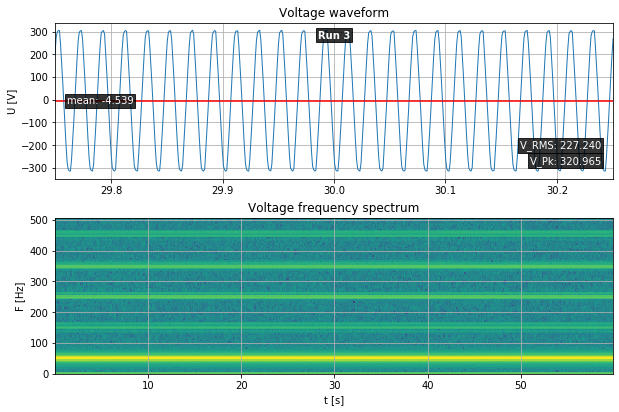

In [9]:
fig, (top, bottom) = plt.subplots(2, figsize=(9,6))
fig.tight_layout(pad=3, h_pad=1.8)

range_start, range_len = -300, 60 # [s]

data_slice = data[ int(range_start * sampling_rate) : int((range_start + range_len) * sampling_rate) ]

top.grid()
top.plot(np.linspace(0, range_len, int(range_len*sampling_rate)), data_slice, lw=1.0)
top.set_xlim([range_len/2-0.25, range_len/2+0.25])
mean = np.mean(data_interp)
rms = np.sqrt(np.mean(np.square(data_interp - mean)))
peak = np.max(np.abs(data_interp - mean))
top.axhline(mean, color='red')
bbox = {'facecolor': 'black', 'alpha': 0.8, 'pad': 2}
top.text(0.02, 0.5, f'mean: {mean:.3f}', transform=top.transAxes, color='white', bbox=bbox, ha='left', va='center')
top.text(0.98, 0.2, f'V_RMS: {rms:.3f}', transform=top.transAxes, color='white', bbox=bbox, ha='right')
top.text(0.98, 0.1, f'V_Pk: {peak:.3f}', transform=top.transAxes, color='white', bbox=bbox, ha='right')
top.text(0.5, 0.9, f'Run {run_id}', transform=top.transAxes, color='white', bbox=bbox, ha='center', fontweight='bold')

bottom.grid()
bottom.specgram(data_slice, Fs=sampling_rate)
top.set_ylabel('U [V]')
bottom.set_ylabel('F [Hz]')
bottom.set_xlabel('t [s]')

top.set_title('Voltage waveform')
bottom.set_title('Voltage frequency spectrum')
None

# Calculate Short-Time Fourier Transform of capture

In [10]:
def calc_stft(data, fs=sampling_rate, ff:'Hz nominal'=50.0):
    analysis_periods = 10
    window_len = 256 # fs * analysis_periods/ff
    nfft_factor = 1
    sigma = window_len/8 # samples

    f, t, Zxx = signal.stft(data,
                fs = fs,
                window=('gaussian', sigma),
                nperseg = window_len,
                nfft = window_len * nfft_factor)
    print(f'Window length: {window_len:.0f} sp, zero-padded to {window_len * nfft_factor:.0f} sp')
    stft_output_sampling_rate = 1.0/(t[1] - t[0])
    print('STFT sampling rate:', stft_output_sampling_rate)
    return f, t, Zxx, stft_output_sampling_rate

f, t, Zxx, stft_output_sampling_rate = calc_stft(data)

Window length: 256 sp, zero-padded to 256 sp
STFT sampling rate: 7.91015625


## Show a preview of STFT results

Cut out our approximate frequency range of interest

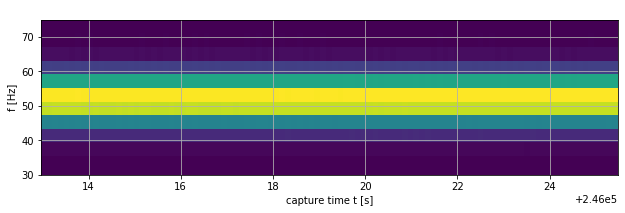

In [11]:
fig, ax = plt.subplots(figsize=(9, 3))
fig.tight_layout(pad=2, h_pad=0.1)

ax.pcolormesh(t[-200:-100], f[:250], np.abs(Zxx[:250,-200:-100]))
ax.set_title(f"Run {last_run}", pad=-20, color='white')
ax.grid()
ax.set_ylabel('f [Hz]')
ax.set_ylim([30, 75]) # Hz
ax.set_xlabel('capture time t [s]')
None

# Run Gasior and Gonzalez for precise frequency estimation

Limit analysis to frequency range of interest. If automatic adaption to totally different frequency ranges
(e.g. 400Hz) would be necessary, we could switch here based on configuration or a lookup of the STFT bin
containing highest overall energy.

As elaborated in the Gasior and Gonzalez Paper [1] the shape of the template function should match the expected peak shape.
Peak shape is determined by the STFT window function. As Gasior and Gonzalez note, a gaussian is a very good fit for a steep gaussian window.

In [12]:
def runner(args):
    frame_f, frame_Z, le_t = args
    # Template function. We use a gaussian here. This function needs to fit the window above.
    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))

    # Calculate initial values for curve fitting
    f_start = frame_f[np.argmax(frame_Z)] # index of strongest bin index
    A_start = np.max(frame_Z) # strongest bin value
    p0 = [A_start, f_start, 1.]
    try:
        # Fit template to measurement data STFT ROI 
        coeff, var = optimize.curve_fit(gauss, frame_f, frame_Z, p0=p0)
        _A, rv, _sigma, *_ = coeff # The measured frequency is the mean of the fitted gaussian
        return rv

    except Exception as e:
        # Handle fit errors
        return np.nan

def gasior_gonzalez_fmeas(f, t, Zxx):
    import multiprocessing

    chunksize = 1000

    n_f, n_t = Zxx.shape
    # Frequency ROI
    f_min, f_max = 30, 70 # Hz
    # Indices of bins within ROI
    bounds_f = slice(np.argmax(f > f_min), np.argmin(f < f_max))

    # Initialize output array
    f_mean = np.zeros(Zxx.shape[1])

    jobs = {}
    with multiprocessing.Pool(multiprocessing.cpu_count()) as pool, tqdm(total=Zxx.shape[1]-2) as tq:
        # Iterate over STFT time slices
        for le_t in range(0, Zxx.shape[1], chunksize):
            # Cut out ROI and compute magnitude of complex fourier coefficients
            jobs[le_t] = pool.map_async(runner, [
                    (f[bounds_f], np.abs(Zxx[bounds_f, frame_t]), frame_t) for frame_t in range(le_t, min(Zxx.shape[1], le_t+chunksize))
                ], callback=lambda _x: tq.update(chunksize))

        pool.close()
        for le_t, future in jobs.items():
            f_mean[le_t:le_t+chunksize] = future.get()
        pool.join()

    # Cut off invalid values at fringes
    return f_mean[1:-2], t[1:-2]

f_mean, f_mean_t = gasior_gonzalez_fmeas(f, t, Zxx)

## Produce plots of measurement results

### Plot results as time-series data
Include measurements of mean, standard deviation and variance of measurement data

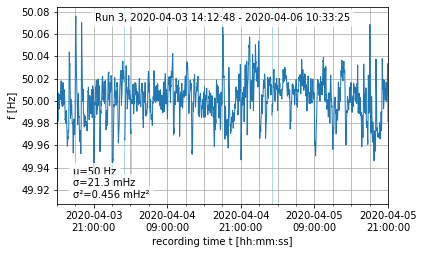

In [15]:
pdate = lambda s: dates.date2num(datetime.datetime.fromisoformat(s))
td2num = lambda td: dates.date2num(start + datetime.timedelta(seconds=td))

def plot_freq_trace(outfile, xlim=None, minor_locator=dates.HourLocator(interval=3), major_locator=dates.HourLocator(interval=12), smooth_sec=None):
    fig, ax = plt.subplots(figsize=(6, 4), sharex=True)
    fig.tight_layout(pad=3.5, h_pad=0, w_pad=1)

    if smooth_sec is not None:
        # smooth data by convolving with a blackman window
        a = int(10 * smooth_sec)
        a = a//2*2 + 1 # make a odd
        w = np.blackman(a)
        f_smooth = np.convolve(w/w.sum(), f_mean, mode='valid')
        t_smooth = f_mean_t[a//2:-a//2+1]
    else:
        f_smooth = f_mean
        t_smooth = f_mean_t
    
    ax.plot([ td2num(td) for td in t_smooth ], f_smooth, lw=1)
    ax.set_ylabel('f [Hz]')
    
    var = np.var(f_mean[~np.isnan(f_mean)][1:-1])
    mean = np.mean(f_mean[~np.isnan(f_mean)][1:-1])
    ax.text(0.5,  0.93, f'Run {run_id}, {time_window}', transform=ax.transAxes, ha='center', bbox=dict(fc='white', alpha=0.8, ec='none'))
    ax.text(0.05, 0.15, f'μ={mean:.3g} Hz', transform=ax.transAxes, ha='left', bbox=dict(fc='white', alpha=0.8, ec='none'))
    ax.text(0.05, 0.09, f'σ={np.sqrt(var) * 1e3:.3g} mHz', transform=ax.transAxes, ha='left', bbox=dict(fc='white', alpha=0.8, ec='none'))
    ax.text(0.05, 0.03, f'σ²={var * 1e3:.3g} mHz²', transform=ax.transAxes, ha='left', bbox=dict(fc='white', alpha=0.8, ec='none'))

    # Indicate missing values
    for i in np.where(np.isnan(f_mean))[0]:
        ax.axvspan(td2num(t[i]), td2num(t[i+1]), color='lightblue')

    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_minor_locator(minor_locator)
    formatter = dates.DateFormatter('%Y-%m-%d\n%H:%M:%S')
    ax.xaxis.set_major_formatter(formatter)
    ax.set_xlabel('recording time t [hh:mm:ss]')
    ax.grid(True, which='both')
    if xlim is not None:
        ax.set_xlim(xlim)
    fig.savefig(f'fig_out/{outfile}.pdf')
    None
    
plot_freq_trace('freq_meas_trace_24h',
                xlim=[pdate('2020-04-03 15:00:00'), pdate('2020-04-05 21:00:00')],
                smooth_sec=60*5,
               )

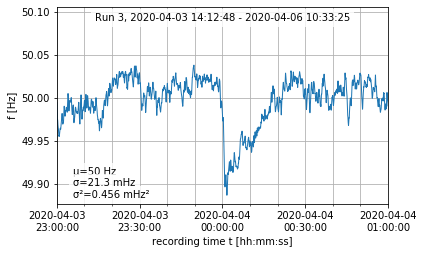

In [16]:
plot_freq_trace('freq_meas_trace_2h_1',
                xlim=[pdate('2020-04-03 23:00:00'), pdate('2020-04-04 01:00:00')],
                smooth_sec=10,
                minor_locator=dates.MinuteLocator(interval=10),
                major_locator=dates.MinuteLocator(interval=30))

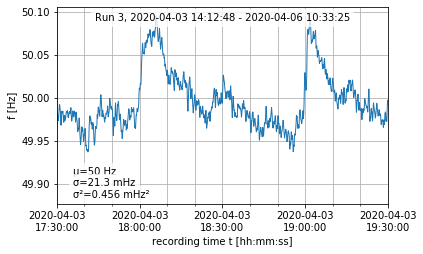

In [17]:
plot_freq_trace('freq_meas_trace_2h_2',
                xlim=[pdate('2020-04-03 17:30'), pdate('2020-04-03 19:30:00')],
                smooth_sec=10,
                minor_locator=dates.MinuteLocator(interval=10),
                major_locator=dates.MinuteLocator(interval=30))

### Plot raw mains voltage spectrum

First compute FFT of voltage, then smoothen and plot

In [19]:
def compute_voltage_fft(data):
    # Number of samplepoints
    N = len(data)
    # sample spacing
    T = 1.0 / sampling_rate
    x = np.linspace(0.0, N*T, N)
    yf = np.absolute(scipy.fftpack.fft(data * sig.blackman(N)))**2
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

    yf = 2.0/N * np.abs(yf[:N//2])

    average_from = lambda val, start, average_width: np.hstack([val[:start], [ np.mean(val[i:i+average_width]) for i in range(start, len(val), average_width) ]])

    average_width = 6
    average_start = 20
    yf = average_from(yf, average_start, average_width)
    xf = average_from(xf, average_start, average_width)
    yf = average_from(yf, 200, average_width)
    xf = average_from(xf, 200, average_width)
    return xf, yf
#voltage_fft = compute_voltage_fft(data_interp)

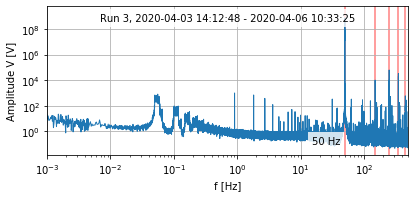

In [20]:
def plot_voltage_spectrum(xf, yf):
    fig, ax = plt.subplots(figsize=(6, 3))
    fig.tight_layout(pad=2.0)

    yf2 = np.copy(yf)
    #chunk_size = 200
    #for i in range(len(yf)-chunk_size, 1, -chunk_size):
    #    yf2 = np.hstack([yf2[:i], sig.savgol_filter(yf2[i:], 23, 3)])

    ax.loglog(xf, yf2, lw=1)
    #ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _pos: f'{1/x:.1f}'))
    ax.set_xlabel('f [Hz]')
    ax.set_ylabel('Amplitude V [V]')
    ax.grid()
    ax.set_xlim([0.001, 500])
    fig.subplots_adjust(bottom=0.2)

    for le_f in (50, 150, 250, 350, 450):
        ax.axvline(le_f, color=(1, 0.5, 0.5), zorder=-2)
    ax.annotate('50 Hz', xy=(15, 0.1), xycoords='data', bbox=dict(fc='white', alpha=0.8, ec='none'))
    ax.text(0.5, 0.9, f'Run {run_id}, {time_window}', transform=ax.transAxes, ha='center', bbox=dict(fc='white', alpha=0.8, ec='none'))
    fig.savefig('fig_out/mains_voltage_spectrum.pdf')
#plot_voltage_spectrum(*voltage_fft)
plot_voltage_spectrum(*compute_voltage_fft(data_interp))

### Plot frequency spectrum

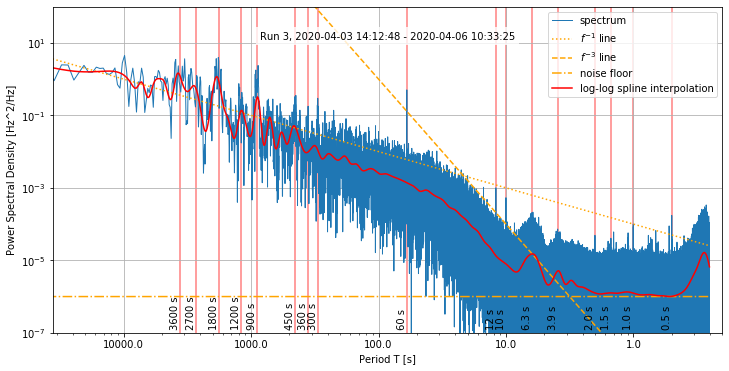

In [33]:
def plot_fmeas_spectrum(data):
    # Number of samplepoints
    newcopy = np.copy(data)
    nans, x = nan_helper(newcopy)
    newcopy[nans]= np.interp(x(nans), x(~nans), newcopy[~nans])

    N = len(newcopy)
    # sample spacing
    T = 1.0 / stft_output_sampling_rate
    x = np.linspace(0.0, N*T, N)
    yf = np.absolute(scipy.fftpack.fft(newcopy * sig.blackman(N)))**2
    xf = np.linspace(0.0, stft_output_sampling_rate/2, N//2)

    yf = 2.0/N * np.abs(yf[:N//2])

    #chunk_size = 200
    #for i in range(len(yf)-chunk_size, 1, -chunk_size):
    #    yf = np.hstack([yf[:i], sig.savgol_filter(yf[i:], 23, 3)])

    fig, ax = plt.subplots(figsize=(12,6))
    ax.loglog(xf, yf, label='spectrum', lw=1)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _pos: f'{1/x:.1f}'))
    ax.set_xlabel('Period T [s]')
    ax.set_ylabel('Power Spectral Density [Hz^2/Hz]')

    for i, t in enumerate([0.5, 1.0, 1.5, 2.0, 3.9, 6.3, 10, 12, 60, 300, 360, 450, 900, 1200, 1800, 2700, 3600]):
        ax.axvline(1/t, color='red', alpha=0.5, zorder=-1)
        ax.annotate(f'{t} s', xy=(1/t, 1e-7), xytext=(-10, 5), xycoords='data', textcoords='offset pixels', rotation=90)
    #ax.text(1/60, 10,'60 s', ha='left')
    ax.grid()
    ax.set_xlim([1/(10*3600), 5])
    ax.set_ylim([1e-7, 1e2])
    ax.autoscale(False) # do not include noise illustration lines in autoscaling
    ax.plot(xf[1:], 1e-4/xf[1:], label='$f^{-1}$ line', color='orange', ls=':')
    ax.plot(xf[1:], 1e-8/(xf[1:]**4), label='$f^{-3}$ line', color='orange', ls='--')
    ax.plot(xf[1:], np.tile(1e-6, len(xf)-1), label='noise floor', color='orange', ls='-.')
    

    #yf2 = np.copy(yf)
    #chunk_size = 50
    #for i in range(len(yf)-chunk_size, 1, -chunk_size):
    #    yf2 = np.hstack([yf2[:i], sig.savgol_filter(yf2[i:], 23, 3)])
    #chunk_size = 2000
    #for i in range(len(yf2)-chunk_size, 1, -chunk_size):
    #    yf2 = np.hstack([yf2[:i], sig.savgol_filter(yf2[i:], 511, 3)])
    #ax.plot(xf, yf2)
    spline_first = 4
    foo = np.log(yf[spline_first:])
    foo_w = np.tile(1, len(foo))
    foo_w[np.isnan(foo)] = 0
    foo[np.isnan(foo)] = 0
    spl = scipy.interpolate.splrep(x=xf[spline_first:], y=foo, w=foo_w, t=np.logspace(-4.5, 0, 100) * (0.45 * stft_output_sampling_rate), task=-1)
    ax.plot(xf[spline_first:], np.exp(scipy.interpolate.splev(xf[spline_first:], spl)), color='red', label='log-log spline interpolation')
    
    ax.text(0.5, 0.9, f'Run {run_id}, {time_window}', transform=ax.transAxes, ha='center', bbox=dict(fc='white', alpha=0.8, ec='none'))

    ax.legend(loc='upper right')
    fig.savefig('fig_out/freq_meas_spectrum.pdf')
    
    return (xf[spline_first], xf[-1], len(xf[spline_first:])), spl
psd_spl_x, psd_spl = plot_fmeas_spectrum(f_mean)

## Export measurement data for modulation simulations

In [34]:
print(f'Invalid samples: {np.sum(np.isnan(f_mean))} / {len(f_mean)} ({np.sum(np.isnan(f_mean))/len(f_mean)*1e6:.1f} ppm)')

with open(f'data/fmeas_export_ocxo_2day.bin', 'wb') as f:
    for sample in f_mean:
        if not np.isnan(sample):
            f.write(struct.pack('<f', sample))

Invalid samples: 24 / 1946198 (12.3 ppm)


/home/user/safety-reset/lab-windows/env/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/user/safety-reset/lab-windows/env/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/user/safety-reset/lab-windows/env/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/user/safety-reset/lab-windows/env/lib/python3.8/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


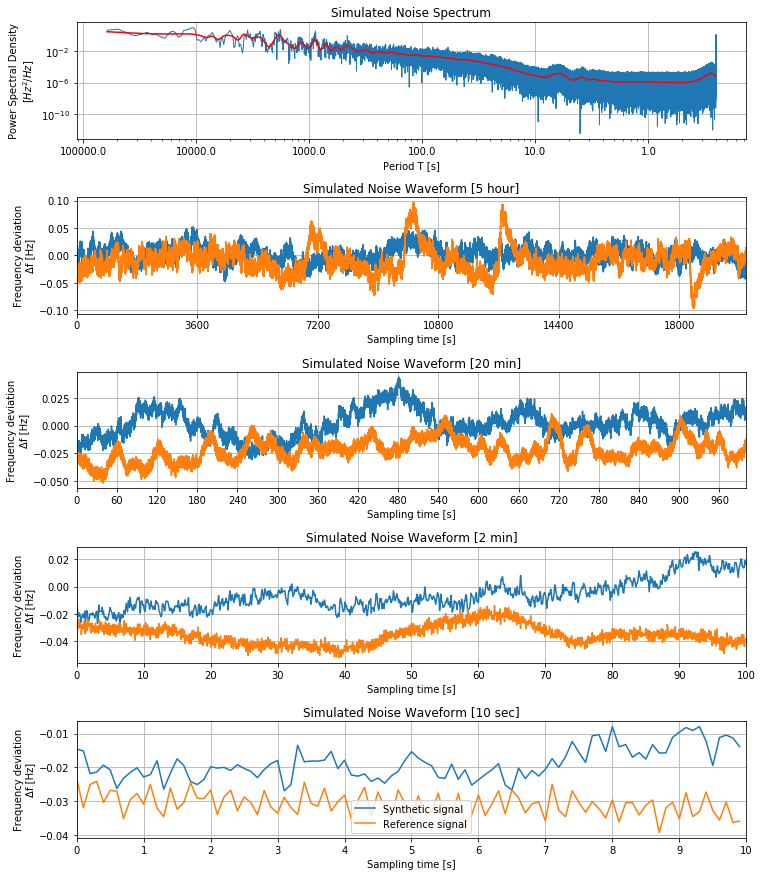

In [35]:
with open(f'grid_freq_psd_spl_{len(psd_spl[1])}pt.json', 'w') as f:
    json.dump({'x_spec': psd_spl_x, 't': psd_spl[0].tolist(), 'c': psd_spl[1].tolist(), 'k': psd_spl[2] }, f)

def generate_synthetic_noise(specfile='grid_freq_psd_spl_108pt.json'):
    with open(specfile) as f:
        d = json.load(f)
        x = np.linspace(*d['x_spec'])
        N = len(x)
        psd_spl = d['t'], d['c'], d['k']
        
    noise = np.random.normal(size=N) * 2
    spec = scipy.fftpack.fft(noise) **2

    spec *= np.exp(scipy.interpolate.splev(x, psd_spl))

    spec **= 1/2
    
    renoise = scipy.fftpack.ifft(spec)
    return x, renoise

def noise_sim(specfile='grid_freq_psd_spl_108pt.json'):
    x, renoise = generate_synthetic_noise(specfile)
    N = len(x)
    respec = 2.0/N * np.absolute(scipy.fftpack.fft(renoise * np.blackman(N))) ** 2
    
    #xf = np.linspace(0, 10/2, N//2)
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(12, 15), gridspec_kw={'hspace': 0.5})
    
    ax1.loglog(x, respec, lw=1)
    ax1.plot(x, np.exp(scipy.interpolate.splev(x, psd_spl)), color='red', label='log-log spline interpolation')
    ax1.grid()
    ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _pos: f'{1/x:.1f}'))
    ax1.set_xlabel('Period T [s]')
    ax1.set_ylabel('Power Spectral Density\n[$Hz^2/Hz$]')
    ax1.set_title('Simulated Noise Spectrum')
    def plot_sigs(ax, lims, tick_ivl, legend_loc=None, title=None):
        ax.plot(renoise[slice(*lims)], label='Synthetic signal')
        ax.plot(f_mean[slice(*lims)] - np.mean(f_mean[~np.isnan(f_mean)]), label='Reference signal')
        ax.grid()
        if legend_loc is not None:
            ax.legend(loc=legend_loc)
        ax.set_ylabel('Frequency deviation\nΔf [Hz]')
        ax.set_xlabel('Sampling time [s]')
        ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _pos: f'{x/10:.0f}'))
        ax.xaxis.set_major_locator(plt.MultipleLocator(tick_ivl * 10.0))
        ax.set_xlim([0, lims[1]-lims[0]])
        if title:
            ax.set_title(title)
    plot_sigs(ax2, [10000, 210000], 3600, title='Simulated Noise Waveform [5 hour]')
    plot_sigs(ax3, [10000, 20000], 60, title='Simulated Noise Waveform [20 min]')
    plot_sigs(ax4, [10000, 11000], 10, title='Simulated Noise Waveform [2 min]')
    plot_sigs(ax5, [10000, 10100], 1, legend_loc='lower center', title='Simulated Noise Waveform [10 sec]')
    
    return fig
    
noise_sim().savefig('fig_out/simulated_noise_spectrum.pdf')

Window length: 256 sp, zero-padded to 256 sp
STFT sampling rate: 7.91015625



0.0012170400234126895


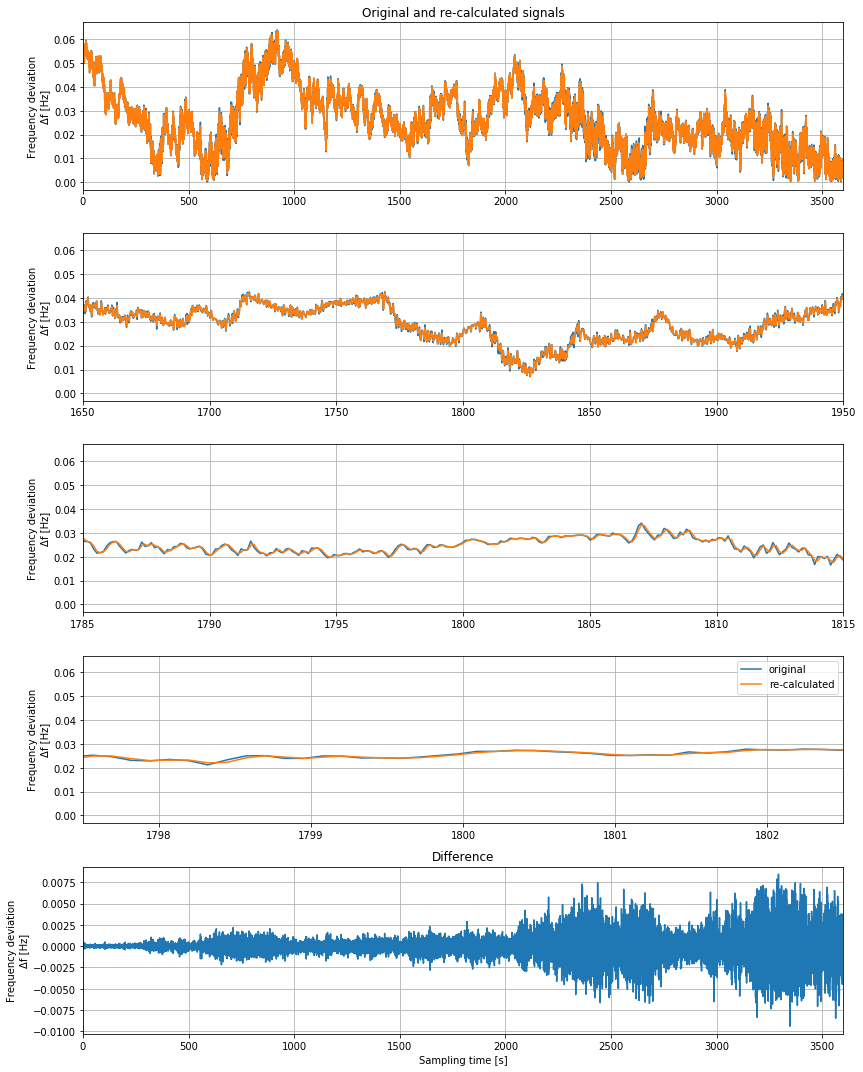

In [77]:
def do_artificial_noise_simulation(duration:'seconds' = 3600.0, sampling_rate=sampling_rate):
    t_pad = 1000.0
    offx = int(t_pad*stft_output_sampling_rate)
    
    _x, noise_freqs = generate_synthetic_noise()
    noise_freqs = np.absolute(noise_freqs)[offx:][:int(duration * stft_output_sampling_rate) + 1]
    x = np.linspace(0, duration, int(duration*sampling_rate))
    noise_resampled = np.interp(x, np.linspace(0, len(noise_freqs)/stft_output_sampling_rate, len(noise_freqs)), noise_freqs)
    
    phase_acc = 0.0
    out = np.zeros(len(noise_resampled))
    for i, f in enumerate(noise_resampled):
        phase_acc += 2*np.pi*(50.0 + f) / sampling_rate
        out[i] = np.sin(phase_acc)
        if phase_acc > 2*np.pi:
            phase_acc -= 2*np.pi
            
    return out, noise_freqs

def recalc_f(duration=3600.0):
    new_data, orig_noise = do_artificial_noise_simulation(duration, sampling_rate)
    f, t, Zxx, stft_output_sampling_rate = calc_stft(new_data, sampling_rate)
    #plt.matshow(np.absolute(Zxx), aspect='auto')
    f_mean, t = gasior_gonzalez_fmeas(f, t, Zxx)
    return t, f_mean, orig_noise

def feedback_plot(duration=3600):
    fig, axs = plt.subplots(5, 1, figsize=(12, 15))
    new_t, new_mean, orig_noise = recalc_f()
    for ax, time_range in zip(axs.flatten(), (duration, 300, 30, 5)):
        ax.plot(new_t, orig_noise[1:-1], label='original')
        ax.plot(new_t, new_mean - 50, label='re-calculated')
        ax.grid()
        ax.set_xlim((duration/2-time_range/2, duration/2+time_range/2))
        ax.set_ylabel('Frequency deviation\nΔf [Hz]')
    axs[-2].legend()
    delta = orig_noise[1:-1] - (new_mean - 50)
    print(np.sqrt(np.mean(np.square(delta))))
    axs[-1].plot(new_t, delta)
    axs[-1].set_xlabel('Sampling time [s]')
    axs[-1].set_xlim((0, duration))
    axs[-1].grid()
    axs[-1].set_title('Difference')
    axs[-1].set_ylabel('Frequency deviation\nΔf [Hz]')
    axs[0].set_title('Original and re-calculated signals')
    fig.tight_layout()
    return fig

feedback_plot().savefig('fig_out/freq_meas_feedback.pdf')

# References

1. **Gasior, M. & Gonzalez, J.** Improving FFT frequency measurement resolution by parabolic and gaussian interpolation *CERN-AB-Note-2004-021, CERN-AB-Note-2004-021, 2004*